In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Read & Write Point Clouds

In [2]:
points_path = "pointclouds\VHF_skull.ply"
pcd = o3d.io.read_point_cloud(points_path)

In [3]:
pcd_syn = o3d.geometry.PointCloud()
pcd_syn.points = o3d.utility.Vector3dVector([[0, 0, 0], [1, 0, 0], [0, 1, 0]])
o3d.io.write_point_cloud("pointclouds\synthetic.ply", pcd_syn)

True

### Visualizing

In [4]:
def show3d(models, window_name="Open3D View", width=1280, height=720, background=[1, 1, 1], point_size=2.0, normals=False, zoom=0.8):
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=window_name, width=width, height=height)
    for model in models:
        vis.add_geometry(model)

    opt = vis.get_render_option()
    opt.background_color = background
    opt.point_size = point_size
    opt.show_coordinate_frame = True
    opt.mesh_show_back_face = True
    
    ctr = vis.get_view_control()
    ctr.set_zoom(zoom)
    ctr.rotate(0.0, -500.0)
    
    if normals and isinstance(models[0], o3d.geometry.PointCloud):
       o3d.geometry.PointCloud.estimate_normals(models[0])
       
    
    vis.run()
    vis.destroy_window()

In [5]:
# show3d([pcd])

#### Visualizing with matplotlib

using matplotlib to visualizing point clouds in jupyter notebook's cells.

In [6]:
def show_inline(pcd, m =20, draw_norms=False):
    pts = np.asarray(pcd.points)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pts[::m, 0], pts[::m, 1], pts[::m, 2], s=1)
    
    if draw_norms:
        norms = np.asarray(pcd.normals)

        ax.quiver(pts[::m, 0], pts[::m, 1], pts[::m, 2], norms[::m, 0], norms[::m, 1], norms[::m, 2], length=8, color='red')

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title("Point Cloud Normals (Matplotlib)", fontsize=10)
    plt.show()


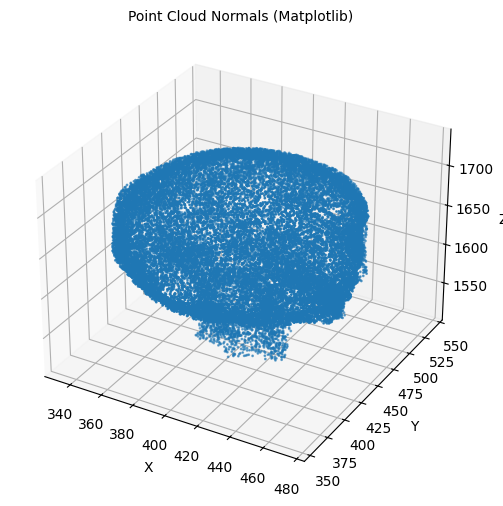

In [7]:
show_inline(pcd)

using matplotlib to visualizing mesh.

In [8]:
def show_inline_mesh(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                    triangles=triangles,
                    color='gray', edgecolor='none', alpha=1.0)

    ax.set_title("3D Mesh Visualization in Matplotlib")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1,1,1]) 
    plt.show()

### Transformation 

#### Translate

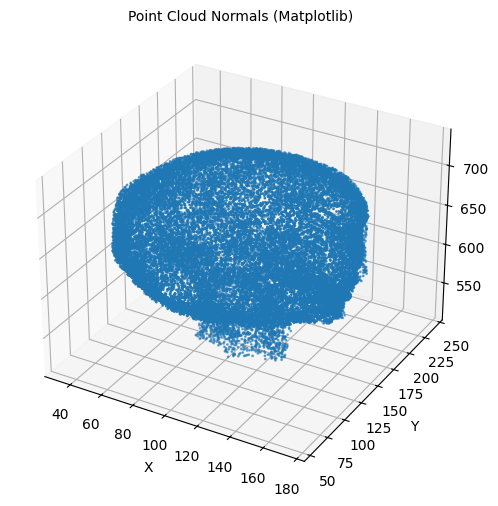

In [9]:
translation = np.array([-300, -300, -1000])
pcd.translate(translation)
show_inline(pcd)

##### Translate to center

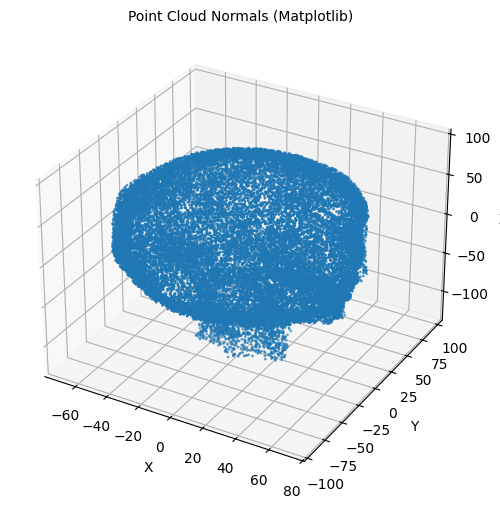

In [10]:
model_center = pcd.get_center()
pcd.translate(-model_center)
show_inline(pcd)

#### Rotate

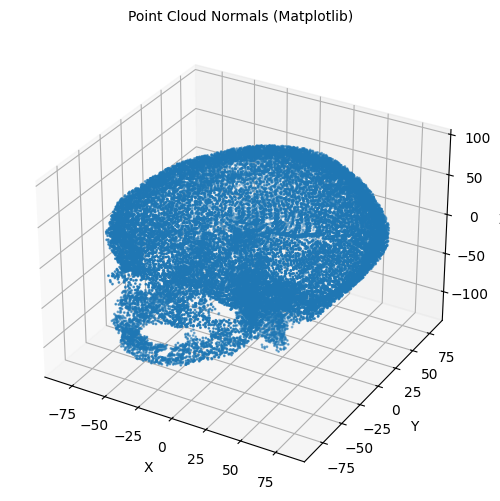

In [11]:
R = pcd.get_rotation_matrix_from_xyz([0,0,3*np.pi/4])
pcd.rotate(R, center=pcd.get_center())

show_inline(pcd)

#### All together

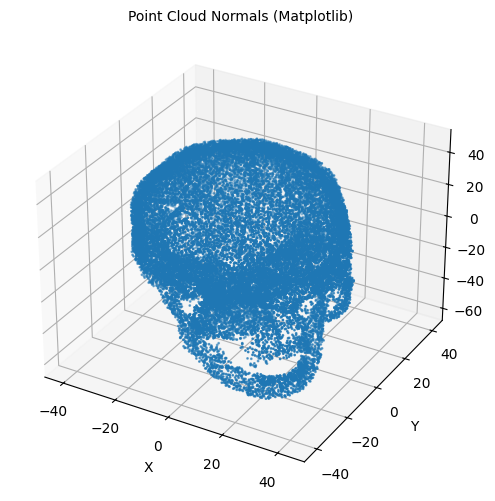

In [12]:
T = np.eye(4)

# Scale
T[:3, :3] *= 0.5

# Rotate
R = o3d.geometry.get_rotation_matrix_from_xyz([0, 0, np.pi/2])
T[:3, :3] = R @ T[:3, :3]

# Translate
T[:3, 3] = np.array([0,0,1])

pcd.transform(T)

show_inline(pcd)

### Point Clouds Downsampling and Noise Removal

In [13]:
clone = copy.deepcopy(pcd)

orginal point cloud has 593934 points and the down-sampled point cloud has 98515 points.


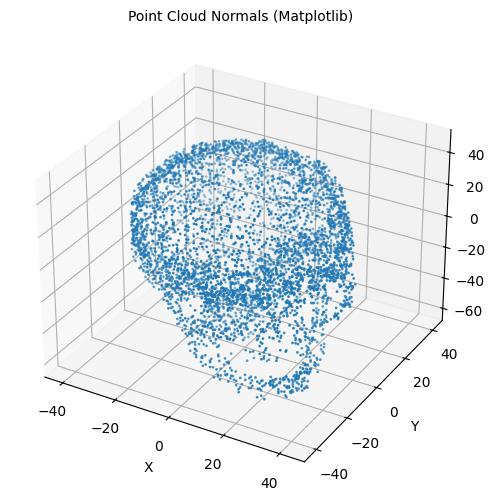

In [14]:
voxel_size = 1
clone_down = clone.voxel_down_sample(voxel_size)


len(pcd.points)
print(f"orginal point cloud has {len(pcd.points)} points and the down-sampled point cloud has {len(clone_down.points)} points." )

# show3d([clone_down])
show_inline(clone_down)

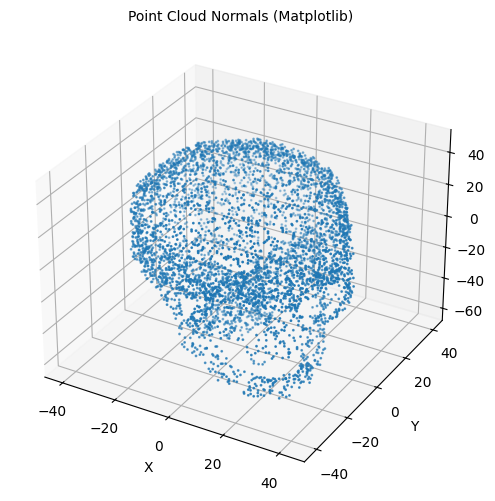

In [15]:
clone_clean, ind = clone_down.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
show_inline(clone_clean)

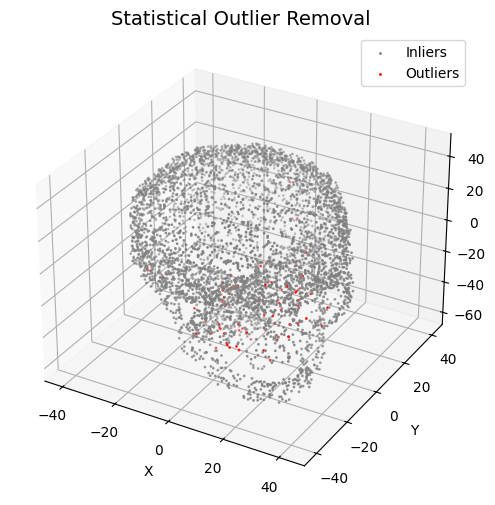

In [16]:
inlier_cloud = clone_down.select_by_index(ind)
outlier_cloud = clone_down.select_by_index(ind, invert=True)

inlier_pts = np.asarray(inlier_cloud.points)
outlier_pts = np.asarray(outlier_cloud.points)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(inlier_pts[::20, 0], inlier_pts[::20, 1], inlier_pts[::20, 2],
           s=1, c='gray', label='Inliers')

ax.scatter(outlier_pts[::20, 0], outlier_pts[::20, 1], outlier_pts[::20, 2],
           s=1, c='red', label='Outliers')

ax.set_title("Statistical Outlier Removal", fontsize=14)
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Visualizing Bounding Box and Crop it

In [17]:
bbox = clone_clean.get_axis_aligned_bounding_box()
bbox.color = (1, 0, 0)
# show3d([clone_clean, bbox])

In [18]:
aabb = o3d.geometry.AxisAlignedBoundingBox(min_bound=(-20,-40,-60), max_bound=(30,40,0))
aabb.color = (0, 1, 0)
# show3d([clone_clean, aabb])

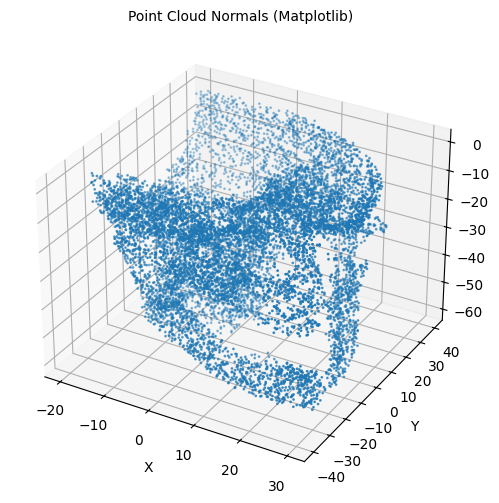

In [19]:
pcd_cropped = pcd.crop(aabb)
show_inline(pcd_cropped)

In [20]:
obb = clone_clean.get_oriented_bounding_box()
obb.color = (0, 0, 1)
# show3d([clone_clean, obb])


In [21]:
# show all boundry boxes in one scene
# show3d([clone_clean, bbox, aabb, obb])

### Normal Estimation and Orientation

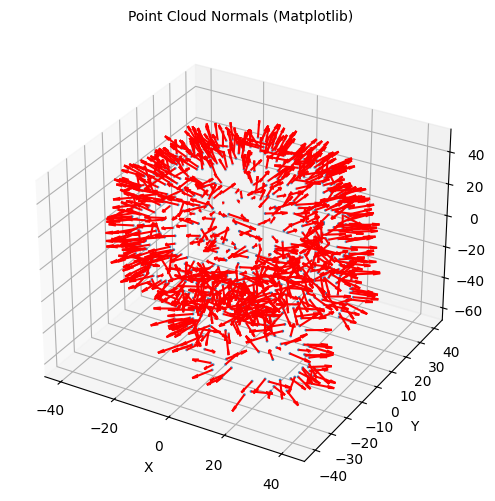

In [22]:
clone_clean.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))
clone_clean.orient_normals_consistent_tangent_plane(50)

show_inline(clone_clean, m=100, draw_norms=True)

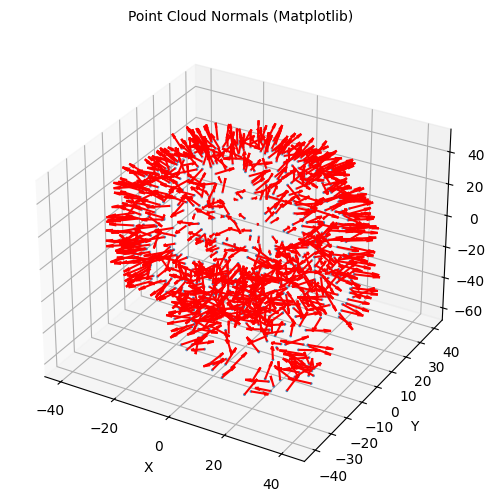

In [23]:
distances = clone_clean.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)

clone_clean.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=2*avg_dist, max_nn=30)) 
clone_clean.orient_normals_consistent_tangent_plane(20)

show_inline(clone_clean, m=100, draw_norms=True)


In [24]:
# o3d.visualization.draw_geometries([clone_clean], point_show_normal=True)

### Point Cloud to Mesh - Surface Reconstruction

TriangleMesh with 204955 points and 408285 triangles.


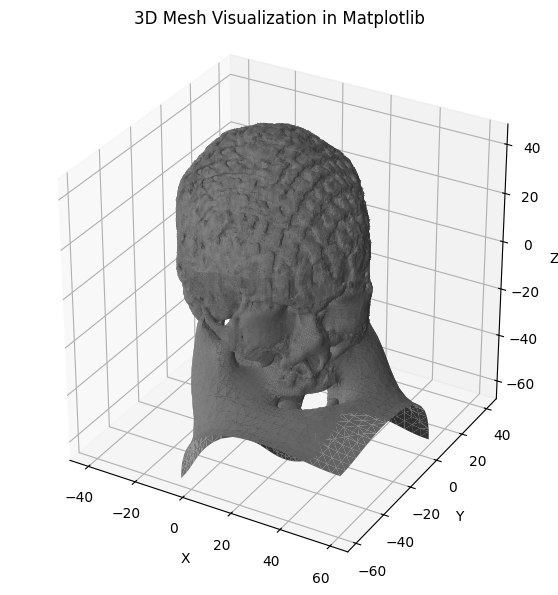

In [25]:
mesh_poisson, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(clone_clean, depth=15)

# print to show number of triangles
print(mesh_poisson)

show_inline_mesh(mesh_poisson)


In [26]:
# show3d([mesh_poisson])

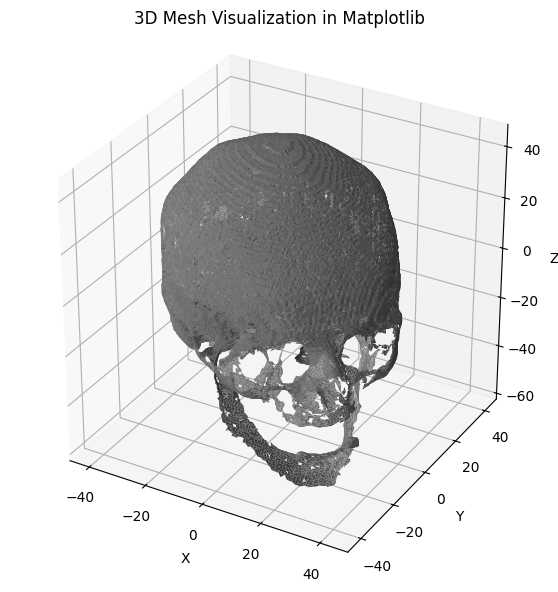

In [27]:
radii = o3d.utility.DoubleVector([
    avg_dist*0.4,
    avg_dist*0.8,
    avg_dist*1.2,
    avg_dist*1.6,
    avg_dist*2.0,
])
mesh_ball = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(clone_clean, radii)

show_inline_mesh(mesh_ball)


In [28]:
# show3d([mesh_ball])

### Mesh Simplification and Smoothing

In [35]:
target_number = int(np.round(len(mesh_ball.triangles)/5))
mesh_simplified = mesh_ball.simplify_quadric_decimation(target_number_of_triangles=target_number)
show3d([mesh_simplified])

In [36]:
smooth_lap = mesh_ball.filter_smooth_laplacian()
show3d([smooth_lap])

In [37]:
smooth_smpl = mesh_ball.filter_smooth_simple(1)
show3d([smooth_smpl])

### Cleaning Mesh - remove unvalid vertecies and triangles

In [38]:
# remove Nan / Inf elements
verts = np.asarray(smooth_lap.vertices)
tris = np.asarray(smooth_lap.triangles)

mask = np.isfinite(verts).all(axis=1)
valid_tris = np.all(mask[tris], axis=1)


verts_clean = verts[mask]
tris_remap = tris[valid_tris]


id_map = np.full(len(mask), -1)
id_map[mask] = np.arange(np.sum(mask))
tris_clean = id_map[tris_remap]

mesh_clean = o3d.geometry.TriangleMesh(
    o3d.utility.Vector3dVector(verts_clean),
    o3d.utility.Vector3iVector(tris_clean)
)

# remove bad elements
mesh_clean.remove_degenerate_triangles()
mesh_clean.remove_duplicated_triangles()
mesh_clean.remove_duplicated_vertices()
mesh_clean.remove_unreferenced_vertices()
mesh_clean.compute_vertex_normals()

TriangleMesh with 26293 points and 48304 triangles.

### Mesh Coloring

In [39]:
mesh_clean.paint_uniform_color([0.8, 0.7, 0.6]) 
mesh_clean.compute_triangle_normals()
mesh_clean.compute_vertex_normals()

show3d([mesh_clean])

### Saving and Exporting Mesh

In [34]:
o3d.io.write_triangle_mesh("meshes/skull_mesh.ply", mesh_clean)

True